<a href="https://colab.research.google.com/github/NielsRogge/Transformers-Tutorials/blob/master/GLPN/GLPN_inference_(depth_estimation).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Notebook: inference with GLPN (Global-Local Path Networks) for monocular depth estimation

In this notebook, we are going to perform inference with [GLPN](https://arxiv.org/abs/2201.07436), which uses [SegFormer](https://huggingface.co/docs/transformers/master/en/model_doc/segformer)'s MiT-b4 (Mix Transformer) as encoder and a lightweight decoder for **monocular depth estimation** from a single image. The architecture (taken from the original paper) is shown below.

![architecture](https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/glpn_architecture.jpg)


## Set-up environment

First, we install HuggingFace Transformers and OpenCV (the latter is not required - it will only be useful for some fancy visualization).

In [14]:
!pip install -q git+https://github.com/huggingface/transformers.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done


In [15]:
!pip install -q opencv-python

## Define model and feature extractor

Next, we instantiate a feature extractor (which can be used to prepare images for the model), and the model itself with weights hosted on the hub.

In [16]:
from transformers import GLPNFeatureExtractor, GLPNForDepthEstimation

feature_extractor = GLPNFeatureExtractor.from_pretrained("vinvino02/glpn-nyu")
model = GLPNForDepthEstimation.from_pretrained("vinvino02/glpn-nyu")

## Prepare image

Let's prepare an image for the model!

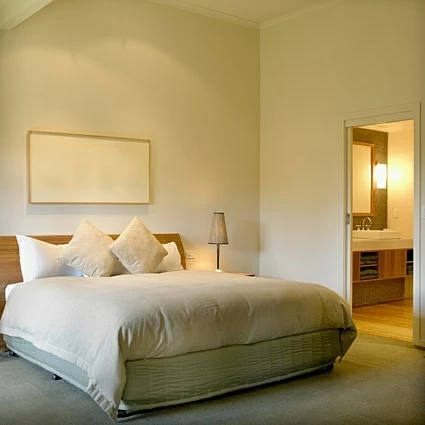

In [17]:
from PIL import Image
import requests

url = 'https://images.all-free-download.com/images/graphicwebp/simple_room_picture_167607.webp'
image = Image.open(requests.get(url, stream=True).raw)
image

In [18]:
pixel_values = feature_extractor(image, return_tensors="pt").pixel_values
print(pixel_values.shape)

torch.Size([1, 3, 416, 416])


## Forward pass

In [19]:
import torch

with torch.no_grad():
  outputs = model(pixel_values)
  predicted_depth = outputs.predicted_depth

In [20]:
predicted_depth.shape

torch.Size([1, 416, 416])

## Visualize

We can visualize the predicted depth in multiple ways. Here's the visualization using Matplotlib:

In [21]:
# interpolate to original size
prediction = torch.nn.functional.interpolate(
                    predicted_depth.unsqueeze(1),
                    size=pixel_values.shape[-2:],
                    mode="bicubic",
                    align_corners=False,
             )
prediction = prediction.squeeze().cpu().numpy()

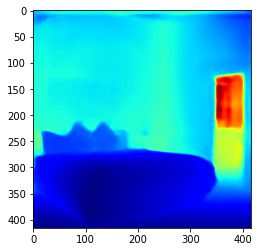

In [22]:
import matplotlib.pyplot as plt

plt.imshow(prediction, cmap="jet")

Alternatively, we can use Numpy and OpenCV:

In [23]:
import numpy as np
import cv2

def write_depth(depth, bits):
  depth_min = depth.min()
  depth_max = depth.max()

  max_val = (2 ** (8 * bits)) - 1

  if depth_max - depth_min > np.finfo("float").eps:
      out = max_val * (depth - depth_min) / (depth_max - depth_min)
  else:
      out = np.zeros(depth.shape, dtype=depth.dtype)

  cv2.imwrite("result.png", out.astype("uint16"), [cv2.IMWRITE_PNG_COMPRESSION, 0])
  
  return

In [24]:
write_depth(prediction, bits=2)

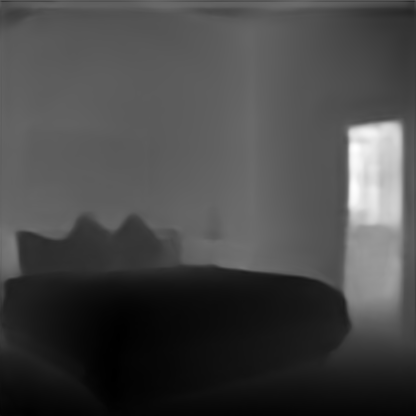

In [25]:
Image.open('result.png')

We can also leverage OpenCV's COLORMAP_RAINBOW functionality for visualization:

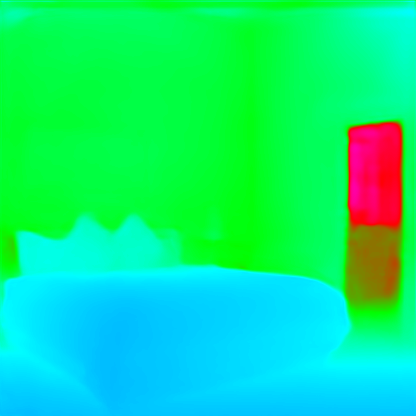

In [26]:
pred_d_numpy = (prediction / prediction.max()) * 255
pred_d_numpy = pred_d_numpy.astype(np.uint8)
pred_d_color = cv2.applyColorMap(pred_d_numpy, cv2.COLORMAP_RAINBOW)
Image.fromarray(pred_d_color)